# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "novel taxa". Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy of "novel taxa" are different from those used for mock and simulated communities.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: assignment == L - 1 (e.g., a novel species is assigned the correct genus)
    * overclassification: assignment == L (e.g., correct genus but assigns to a near neighbor)
    * misclassification: incorrect assignment at L - 1 (e.g., wrong genus-level assignment)
    
Where ``L`` = taxonomic level being tested




## Functions

In [1]:
from tax_credit.taxa_manipulator import *
from tax_credit.framework_functions import *
from tax_credit.eval_framework import heatmap_from_data_frame, parameter_comparisons, method_by_dataset

from os import path, makedirs, remove, rename
from os.path import expandvars, join
from IPython.display import display

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [2]:
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment")
analysis_name = "novel-taxa-simulations"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*', '*'))

This cell performs the classification evaluation and should not be modified.

In [3]:
if not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir, summary_fp)
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_pallette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**match_ratio** = proportion of correct matches. For novel taxa, this means a match at the last common ancestor (level-1)

**overclassification_ratio** = proportion of taxa that were assigned to correct lineage but to a deeper taxonomic level than expected, rather than to LCA. E.g., assignment to another species in the clade

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [4]:
color_pallette = dict(rdp="seagreen", sortmerna="gray", uclust="blue")

y_vars = ["match_ratio", "overclassification_ratio", 
          "underclassification_ratio", "misclassification_ratio"]

## Plot per-level classification accuracy

For novel-taxa analysis, a separate classification is performed at each taxonomic level using different test (unique taxa at level L) and training sets (ref - test taxonomies). Hence, results at each level L represent independent tests, unlike for mock and simulated communities where each level represents the accuracy of each species-level classification trimmed to level L. For novel taxa, results at level L indicate the accuracy with with method M assigns the correct lineage to a "novel" taxon, which is unrepresented in the reference at level L, e.g., level 6 indicates the performance with which each classifier assigns the correct genus to each species. 

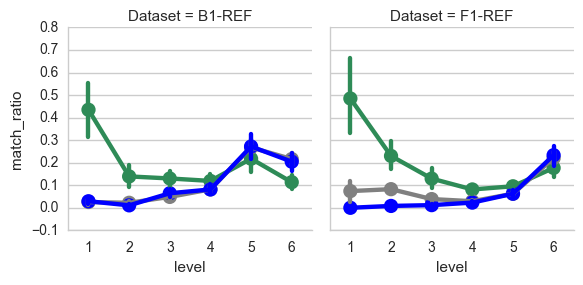

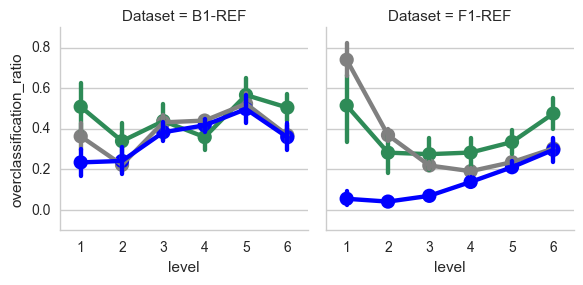

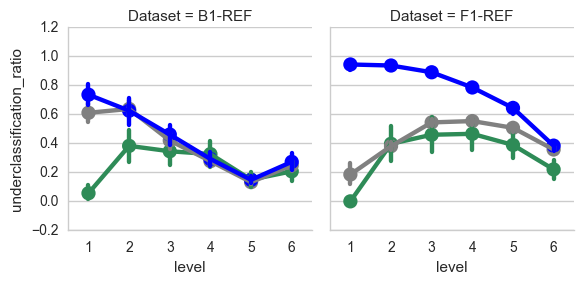

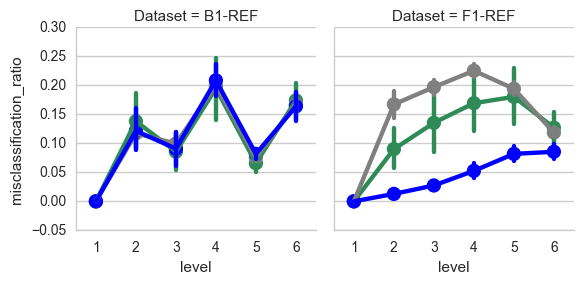

In [5]:
pointplot_from_data_frame(accuracy_results, "level", y_vars, 
                          group_by="Dataset", color_by="Method",
                          color_pallette=color_pallette)

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [6]:
result = per_level_kruskal_wallis(accuracy_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Dataset                   Variable             1             2  \
0  B1-REF                match_ratio  1.140000e-14  8.206860e-10   
1  B1-REF   overclassification_ratio  2.476441e-03  4.480105e-02   
2  B1-REF  underclassification_ratio  5.574738e-14  1.213359e-03   
3  B1-REF    misclassification_ratio  1.000000e+00  7.512295e-01   
4  F1-REF                match_ratio  5.055009e-11  3.298654e-12   
5  F1-REF   overclassification_ratio  1.360042e-14  1.897380e-20   
6  F1-REF  underclassification_ratio  1.746035e-24  8.102140e-23   
7  F1-REF    misclassification_ratio  1.000000e+00  3.298654e-12   

              3             4             5         6  
0  2.528187e-04  1.230393e-01  6.220150e-01  0.002741  
1  4.155972e-01  2.065962e-01  3.588846e-01  0.059492  
2  2.812642e-02  6.220150e-01  4.155972e-01  0.216611  
3  2.431175e-01  7.295186e-01  2.404163e-01  0.778449  
4  4.652818e-08  5.253321e-06  2.428860e-02  0.261391  
5  1.771926e-16  2.892757e-04  1.213359e-03  0.001213  
6  2.684963e-21  5.537442e-14  8.975292e-07  0.000034  
7  6.744161e-22  7.487553e-20  4.853188e-15  0.000432

## Heatmap of method accuracy by parameter

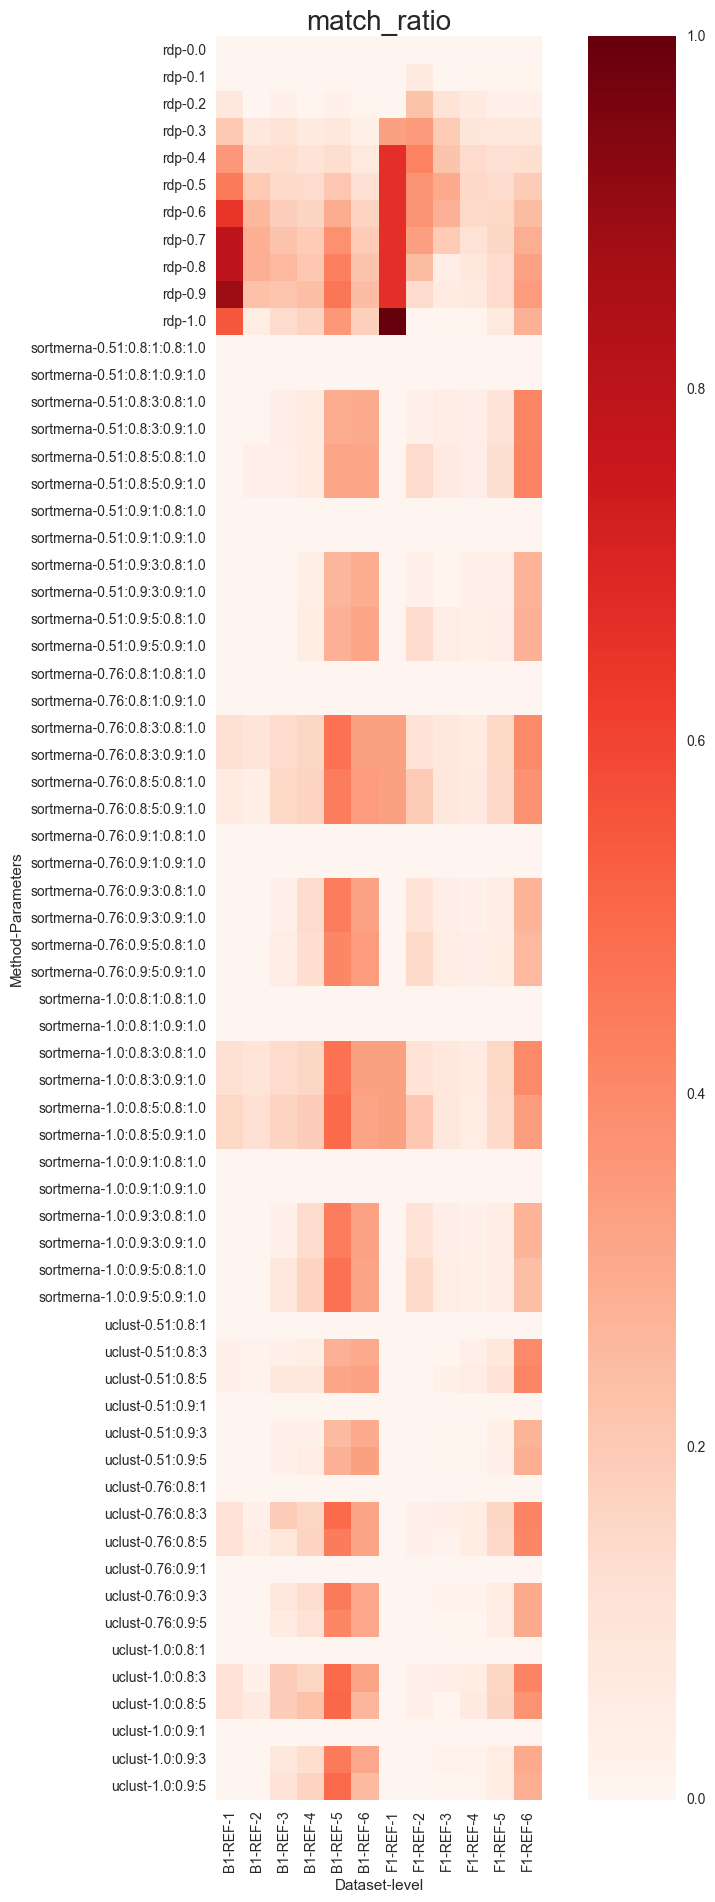

In [7]:
heatmap_from_data_frame(accuracy_results, metric="match_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

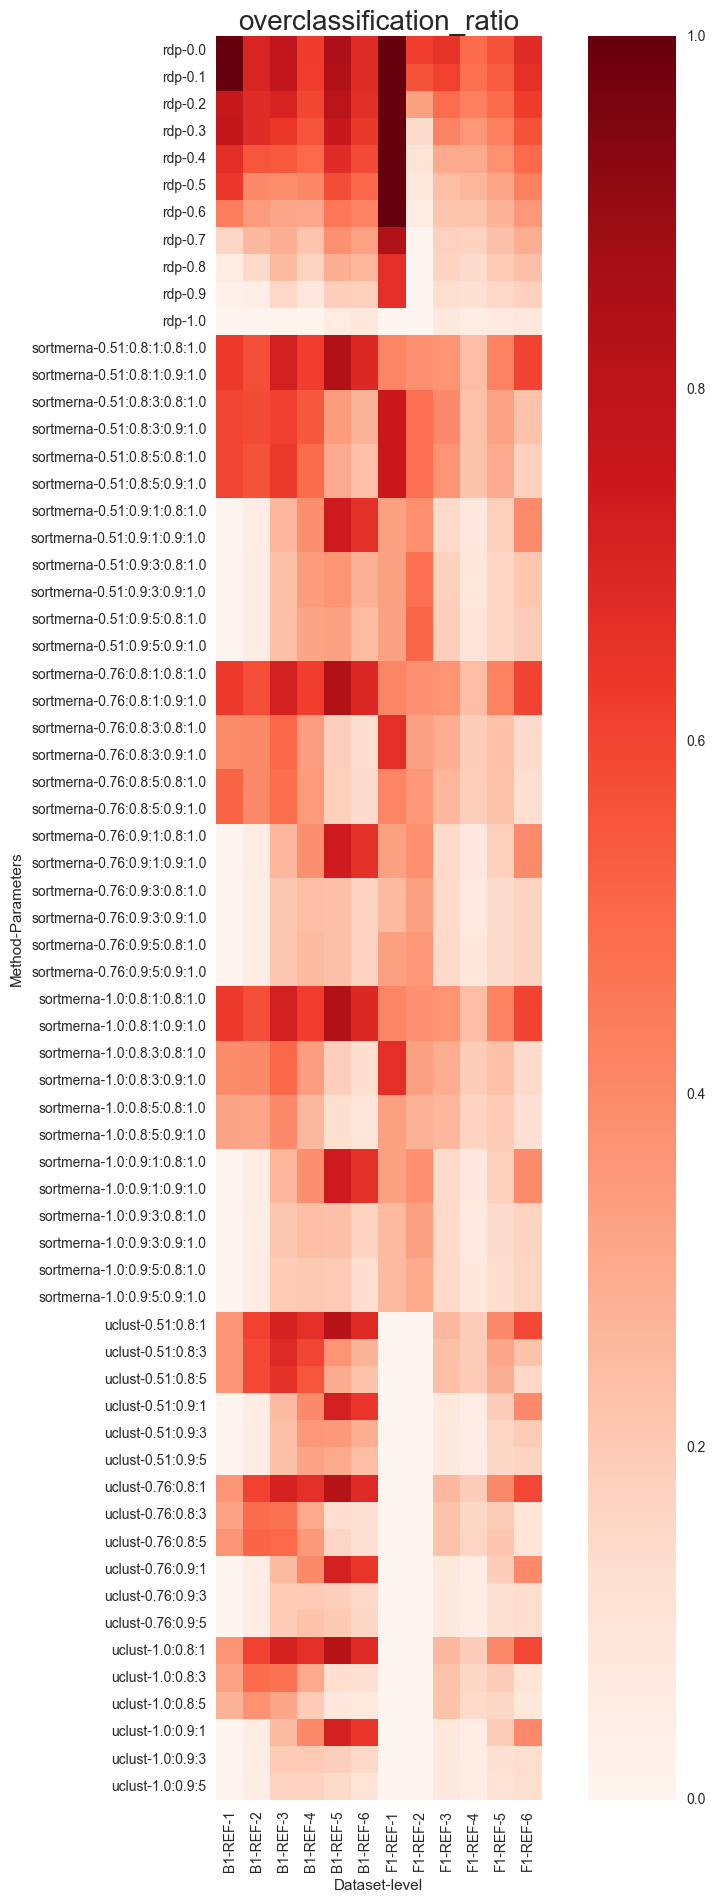

In [11]:
heatmap_from_data_frame(accuracy_results, metric="overclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

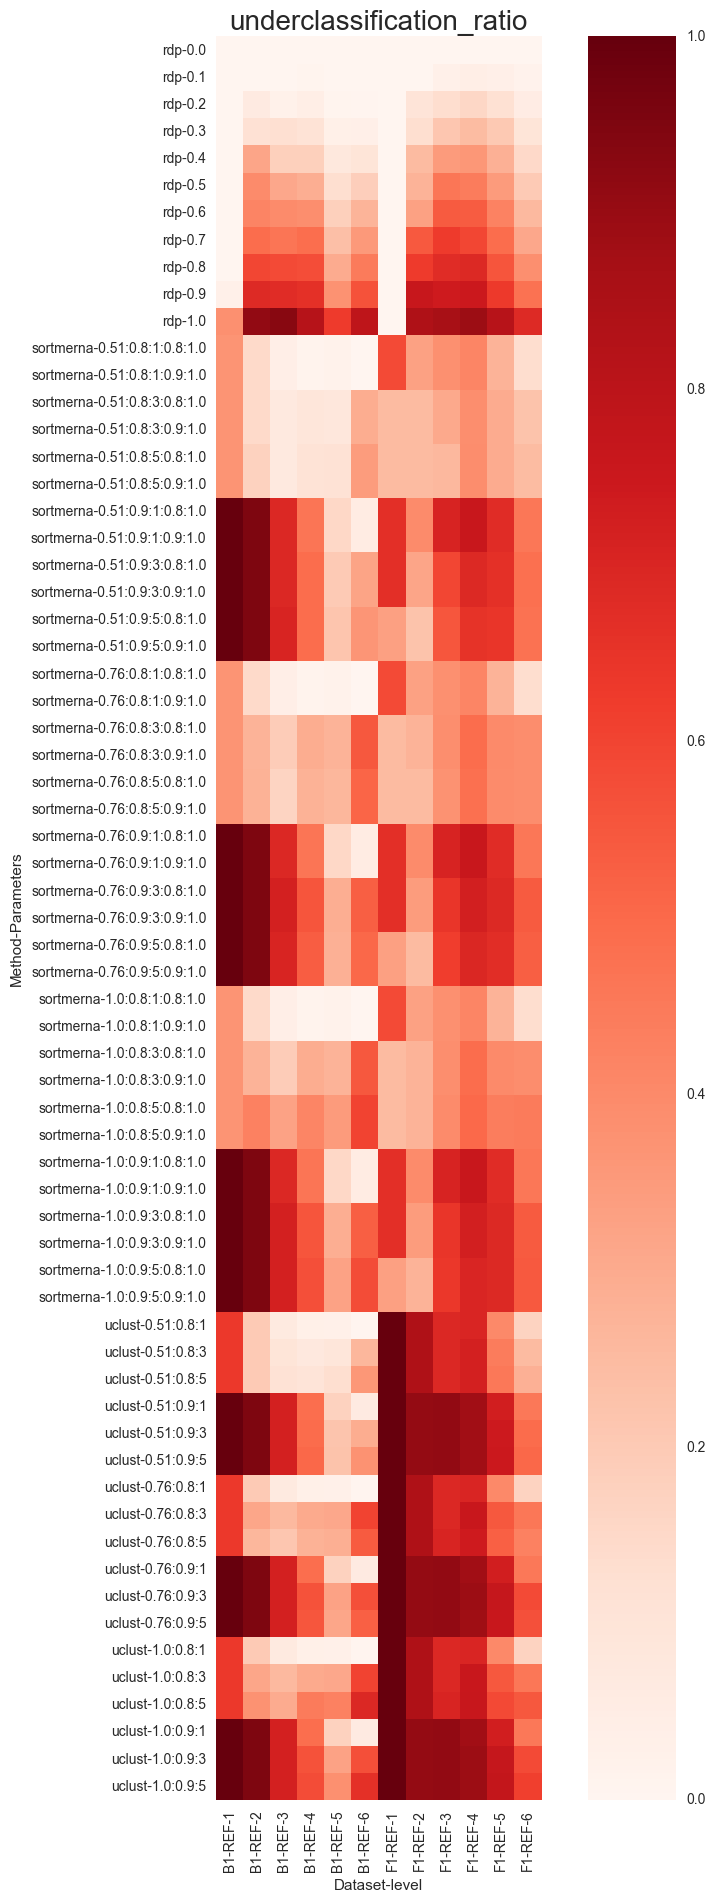

In [12]:
heatmap_from_data_frame(accuracy_results, metric="underclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

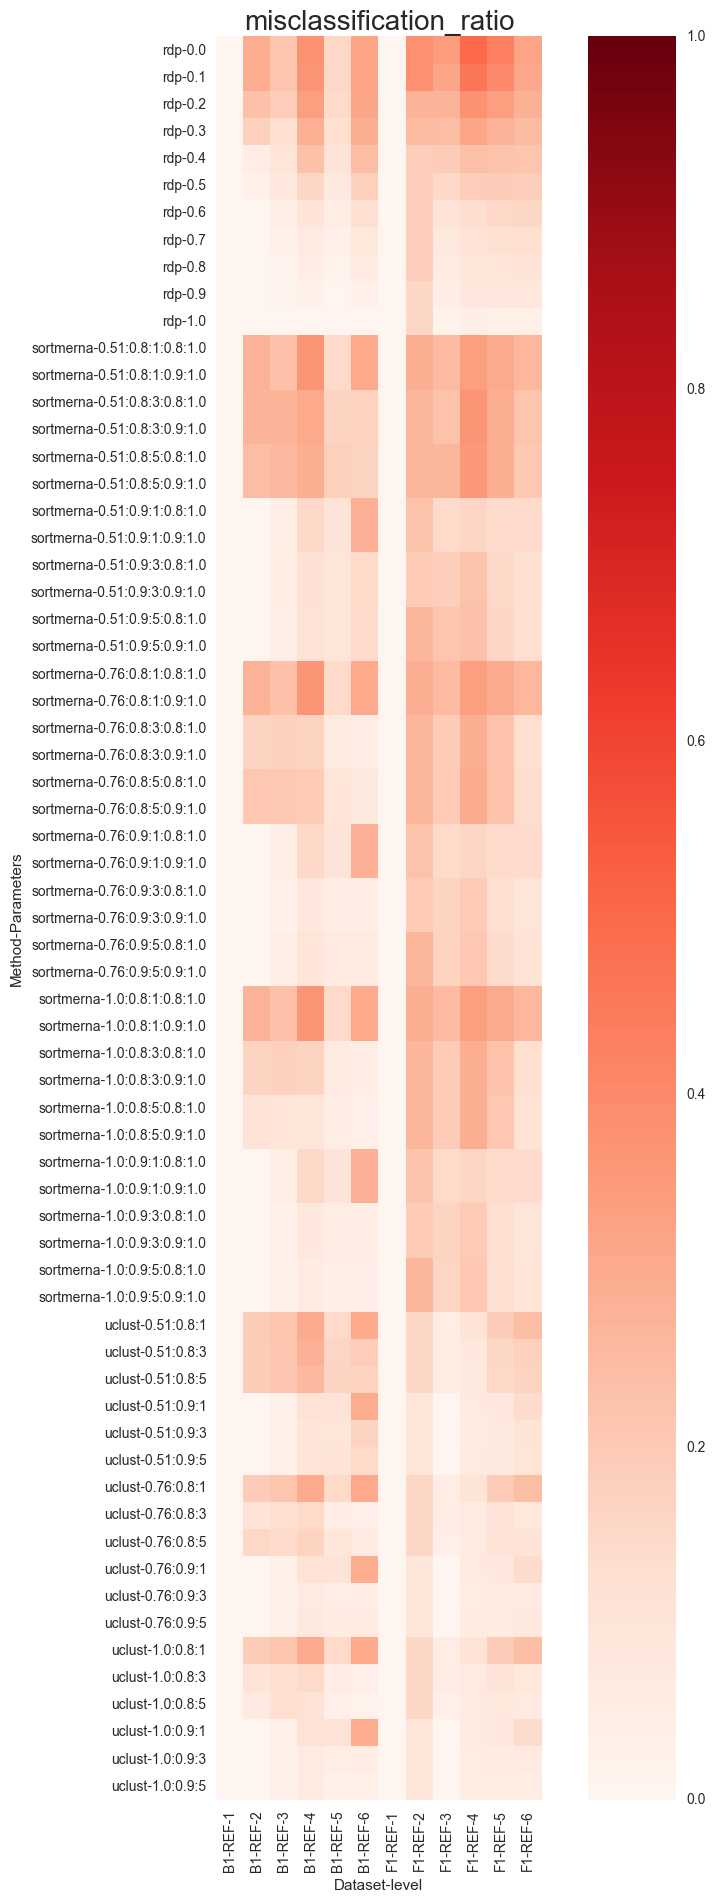

In [13]:
heatmap_from_data_frame(accuracy_results, metric="misclassification_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* column indicates how many samples a given method achieved within one mean absolute deviation of the best result (which is why they sum to more than the total number of samples).

In [8]:
for method in accuracy_results['Method'].unique():
    top_params = parameter_comparisons(accuracy_results[accuracy_results["level"] == 6], method, metrics=["match_ratio"], 
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    print(method)
    display(top_params[:5])

rdp


match_ratio
0.7            6
0.8            6
0.9            6
1.0            5
0.6            3

sortmerna


match_ratio
0.51:0.8:3:0.8:1.0            6
1.0:0.8:3:0.8:1.0             6
0.51:0.8:5:0.8:1.0            6
0.51:0.8:5:0.9:1.0            6
0.76:0.8:3:0.8:1.0            6

uclust


match_ratio
0.51:0.8:3            6
0.51:0.8:5            6
0.51:0.9:5            6
0.76:0.8:3            6
0.76:0.8:5            6

Now we rank the top-performing method/parameter combination for each method from family to species level

In [9]:
for dataset in accuracy_results['Dataset'].unique():
    for level in range(4,7):
        method_rank = method_by_dataset(accuracy_results[accuracy_results["level"] == level],
                                        dataset=dataset, sort_field='match_ratio', 
                                        display_fields=("Method", "Parameters", "match_ratio",
                                                       "misclassification_ratio",
                                                       "overclassification_ratio",
                                                       "underclassification_ratio"))
        print("{0} level {1}".format(dataset, level))
        display(method_rank)

B1-REF level 4


Method         Parameters  match_ratio  misclassification_ratio  \
776     uclust          1.0:0.8:5     0.343284                 0.164179   
724        rdp                0.9     0.298507                 0.014925   
755  sortmerna  1.0:0.8:5:0.9:1.0     0.238806                 0.179104   

     overclassification_ratio  underclassification_ratio  
776                  0.223881                   0.268657  
724                  0.119403                   0.567164  
755                  0.328358                   0.253731

B1-REF level 5


Method         Parameters  match_ratio  misclassification_ratio  \
834     uclust         0.76:0.8:3     0.546539                 0.059666   
884  sortmerna  1.0:0.8:5:0.8:1.0     0.502110                 0.035865   
789        rdp                0.9     0.486874                 0.011933   

     overclassification_ratio  underclassification_ratio  
834                  0.238663                   0.155131  
884                  0.213080                   0.248945  
789                  0.200477                   0.300716

B1-REF level 6


Method          Parameters  match_ratio  misclassification_ratio  \
1074  sortmerna  0.76:0.9:5:0.9:1.0     0.381402                 0.088949   
1089     uclust          0.51:0.8:5     0.358491                 0.214286   
1049        rdp                 0.9     0.254717                 0.047170   

      overclassification_ratio  underclassification_ratio  
1074                  0.176550                   0.353100  
1089                  0.229111                   0.198113  
1049                  0.241240                   0.456873

F1-REF level 4


Method          Parameters  match_ratio  misclassification_ratio  \
1759        rdp                 0.4     0.187500                  0.20000   
1848  sortmerna  0.76:0.8:5:0.9:1.0     0.083333                  0.21875   
1875     uclust          0.76:0.8:5     0.083333                  0.06250   

      overclassification_ratio  underclassification_ratio  
1759                  0.212500                   0.400000  
1848                  0.208333                   0.489583  
1875                  0.208333                   0.645833

F1-REF level 5


Method         Parameters  match_ratio  misclassification_ratio  \
2134     uclust         0.76:0.8:3     0.180157                 0.086162   
1957        rdp                0.7     0.173077                 0.093750   
2052  sortmerna  1.0:0.8:3:0.8:1.0     0.163636                 0.179221   

      overclassification_ratio  underclassification_ratio  
2134                  0.174935                   0.558747  
1957                  0.204327                   0.528846  
2052                  0.212987                   0.444156

F1-REF level 6


Method          Parameters  match_ratio  misclassification_ratio  \
2264     uclust          0.76:0.8:3     0.431737                 0.052695   
2225  sortmerna  0.51:0.8:5:0.8:1.0     0.427545                 0.144910   
2219        rdp                 0.9     0.356886                 0.039521   

      overclassification_ratio  underclassification_ratio  
2264                  0.105389                   0.410180  
2225                  0.157485                   0.270060  
2219                  0.190419                   0.413174